In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import statsmodels.api

In [2]:
data = pd.read_csv("data_P6.csv")
data = pd.DataFrame(data)

In [3]:
customers = pd.read_csv("customers.csv")
customers = pd.DataFrame(customers)

products = pd.read_csv("products.csv")
products = pd.DataFrame(products)

transactions = pd.read_csv("transactions.csv")
transactions = pd.DataFrame(transactions)

### Mise de côté des gros acheteurs

In [4]:
data_out = data.loc[(data['client_id'] == 'c_1609') | (data['client_id'] == 'c_6714') |
                   (data['client_id'] == 'c_3454') | (data['client_id'] == 'c_4958')]

data_original = data.copy()
data = data.drop(data_out.index)

# Demandes de Julie

## Q1 : Corrélation entre genre et catégories de produits

Test du Chi 2 sur les clients uniques

categ,0.0,1.0,2.0
sex,,,
f,4119,4391,1839
m,3773,4058,1754


Le khi2 est de 1.024728095659948
Le d.d.l est de 2
La p-value est de 0.5990776552222239


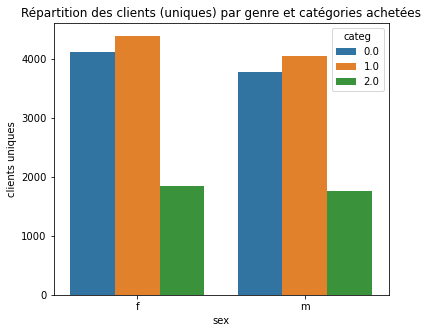

In [5]:
data_uni_clients = data.groupby(['client_id', 'categ', 'sex']).sum().reset_index()
tab = pd.crosstab(data_uni_clients['sex'], data_uni_clients['categ'],margins=True,margins_name='Total')

tab_chi2 = pd.crosstab(data_uni_clients['sex'], data_uni_clients['categ'])
chi2, p, ddl, dep = st.chi2_contingency(tab_chi2)
display(tab_chi2)
print('Le khi2 est de', chi2)
print('Le d.d.l est de', ddl)
print('La p-value est de', p)

stacked = tab_chi2.stack().reset_index().rename(columns={0:'value'})
plt.figure(figsize=(6,5))
sns.barplot(x=stacked['sex'], y=stacked['value'], hue=stacked['categ'])
plt.ylabel("clients uniques")
plt.title("Répartition des clients (uniques) par genre et catégories achetées")
plt.savefig('P6_genre_categ.png', bbox_inches='tight', dpi=150)
plt.show()

In [6]:
femmes = data.loc[data['sex'] =='f']['client_id'].nunique()
hommes = data.loc[data['sex'] =='m']['client_id'].nunique()
print("Quantité de femmes parmi les clients :", femmes)
print("Quantité d'hommes parmi les clients :", hommes)
print("Les femmes représentent environ", '{:.2f}'.format((femmes/len(data.groupby(['client_id']).sum()))*100), "% des acheteurs")

Quantité de femmes parmi les clients : 4478
Quantité d'hommes parmi les clients : 4118
Les femmes représentent environ 52.09 % des acheteurs


Test d'ANOVA sur toutes les transactions

In [7]:
tab = pd.crosstab(data['sex'], data['categ'])
tab = tab.rename(index={'f': 0, 'm':1}).reset_index()

anova_0 = st.f_oneway(tab['sex'], tab[0.0])
anova_1 = st.f_oneway(tab['sex'], tab[1.0])
anova_2 = st.f_oneway(tab['sex'], tab[2.0])
anova_all = st.f_oneway(tab['sex'], tab[0.0], tab[1.0], tab[2.0])

display(tab)
print("ANOVA entre genre et categ 0 :",anova_0)
print("ANOVA entre genre et categ 1 :",anova_1)
print("ANOVA entre genre et categ 2 :",anova_2)
print("ANOVA entre genre et toutes les catégories :",anova_all)

categ,sex,0.0,1.0,2.0
0,0,200793,111331,16980
1,1,186488,101017,15868


ANOVA entre genre et categ 0 : F_onewayResult(statistic=732.9501074767862, pvalue=0.0013615635066281688)
ANOVA entre genre et categ 1 : F_onewayResult(statistic=423.8751937008532, pvalue=0.002350869063548496)
ANOVA entre genre et categ 2 : F_onewayResult(statistic=872.5322644950245, pvalue=0.0011441228980481315)
ANOVA entre genre et toutes les catégories : F_onewayResult(statistic=410.5714301147675, pvalue=1.9625285146949146e-05)


## Q2 : Corrélations liées à l'âge

### Vérification de la distribution des âges des clients

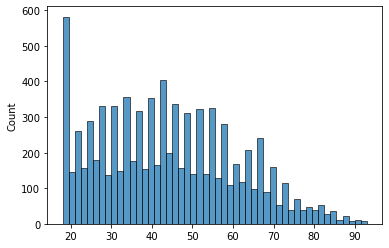

In [8]:
data['age'] = 2022 - data['birth']

data_client = data.groupby(['client_id', 'age', 'birth', 'sex']).sum().reset_index()
matrice_age = data_client['age'].to_numpy()

sns.histplot(matrice_age, bins=50)
plt.savefig('distribution_age.png')
plt.show()

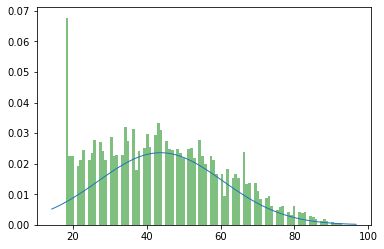

In [9]:
mu = matrice_age.mean() 
std = matrice_age.std()

plt.hist(matrice_age, bins=100, density=True, alpha=0.5, color='g')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = st.norm.pdf(x, mu, std)
plt.plot(x, p, linewidth=1)
plt.show()

### Tests de normalité

Test de Shapiro-Wilk

In [10]:
stat, p = st.shapiro(np.log(matrice_age))
print('Statistics=%.3f, p=%.200f' % (stat, p))

alpha = 0.05/60
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=0.967, p=0.00000000000000000000000000000000000000014109113717900853160302663682312849559408445387977886699513217723172750495130856052128365263342857360839843750000000000000000000000000000000000000000000000000000
Sample does not look Gaussian (reject H0)


C:\Users\Lucie\Anaconda\anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Test de d'Agostino

In [11]:
stat, p = st.normaltest(matrice_age)
print('Statistics=%.3f, p=%.200f' % (stat, p))

alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=504.238, p=0.00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000003206531438223635364825118984101380969561786620604701557148412156567764481425751293536541425
Sample does not look Gaussian (reject H0)


Test de Anderson-Darling

In [12]:
result = st.anderson(matrice_age)
print('Statistic: %.3f' % result.statistic)

for i in range(len(result.critical_values)):
	sl, cv = result.significance_level[i], result.critical_values[i]
	if result.statistic < result.critical_values[i]:
		print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
	else:
		print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

Statistic: 53.763
15.000: 0.576, data does not look normal (reject H0)
10.000: 0.656, data does not look normal (reject H0)
5.000: 0.787, data does not look normal (reject H0)
2.500: 0.918, data does not look normal (reject H0)
1.000: 1.091, data does not look normal (reject H0)


=> Distribution non gaussienne, nous devons utiliser des tests non paramétriques

## Age des clients et montant total des achats

En groupant sur les clients

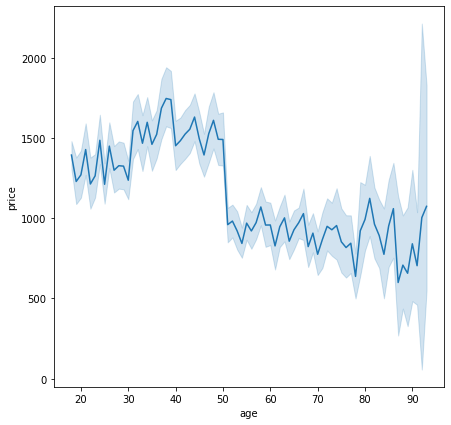

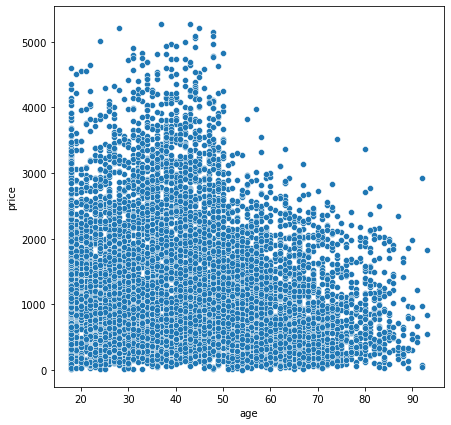

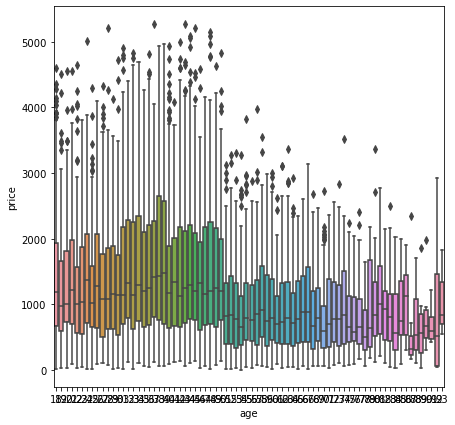

In [13]:
data_client = data.groupby(['client_id', 'age', 'birth', 'sex']).sum().reset_index()

plt.figure(figsize=(7,7))
sns.lineplot(data=data_client, x='age', y='price')
plt.show()

plt.figure(figsize=(7,7))
sns.scatterplot(data=data_client, x='age', y='price')
plt.show()

plt.figure(figsize=(7,7))
sns.boxplot(data=data_client, x='age', y='price')
plt.show()

En groupant sur les âges

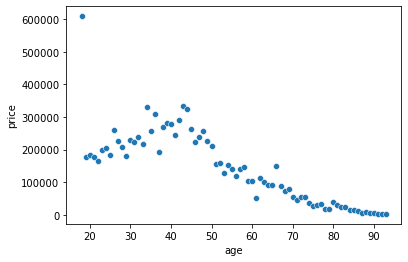

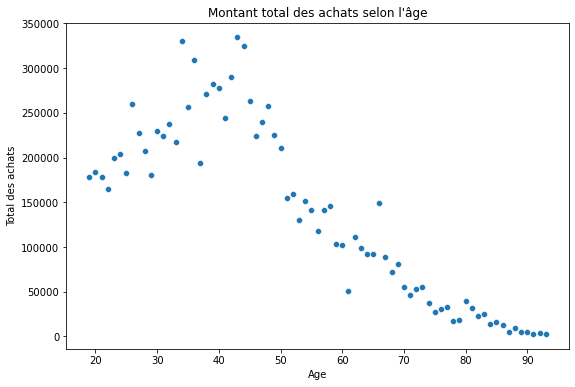

In [14]:
data_birth = data.groupby(['age']).sum().reset_index()

sns.scatterplot(x=data_birth['age'], y=data_birth['price'])
plt.show()

# Mise de côté des acheteurs de 18 ans (outlier)
data_birth_out = data_birth.loc[data_birth['price'] > 400000]
data_birth = data_birth.drop(data_birth_out.index)

plt.figure(figsize=(9,6))
sns.scatterplot(x=data_birth['age'], y=data_birth['price'])
plt.title("Montant total des achats selon l'âge")
plt.xlabel('Age')
plt.ylabel('Total des achats')
plt.savefig('P6_age_total_achat.png', bbox_inches='tight', dpi=150)
plt.show()

Tests de corrélation

In [15]:
matrice_age = data_birth['age'].to_numpy()
matrice_CA = data_birth['price'].to_numpy()

# Test de Pearson effectué, mais pas adapté pour une distribution non paramétrique
pr = st.pearsonr(matrice_age, matrice_CA)

sp = st.spearmanr(matrice_age, matrice_CA)
kd = st.kendalltau(matrice_age, matrice_CA)

print(pr)
print(sp)
print(kd)

(-0.855352112993621, 1.5258080883895737e-22)
SpearmanrResult(correlation=-0.8685633001422475, pvalue=5.906320417882705e-24)
KendalltauResult(correlation=-0.7001801801801802, pvalue=6.230275734670536e-19)


## Age des clients et fréquence d'achats

### Sur le nombre de ventes

En groupant sur les clients

In [16]:
clients_count = data.value_counts('client_id')
clients_count = pd.DataFrame(clients_count).reset_index()
clients_count = clients_count.rename(columns={0: 'total_sales'})
clients_count = clients_count.merge(customers,on='client_id')
clients_count['age'] = 2021 - clients_count['birth']
clients_count['frequency'] = clients_count['total_sales']/clients_count['total_sales'].sum()

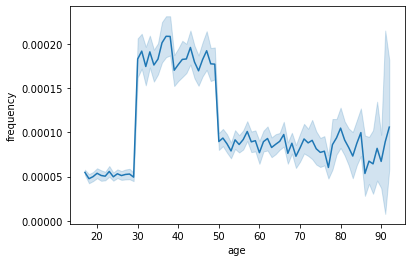

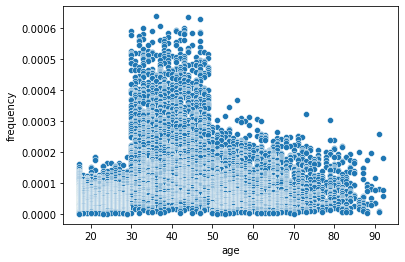

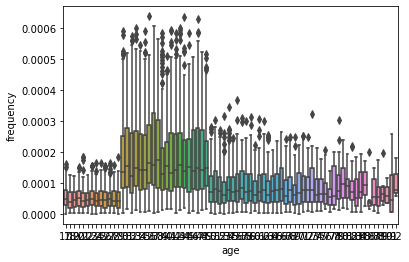

In [17]:
sns.lineplot(x=clients_count['age'], y=clients_count['frequency'])
plt.show()
sns.scatterplot(x=clients_count['age'], y=clients_count['frequency'])
plt.show()
sns.boxplot(x=clients_count['age'], y=clients_count['frequency'])
plt.show()

En groupant sur les âges

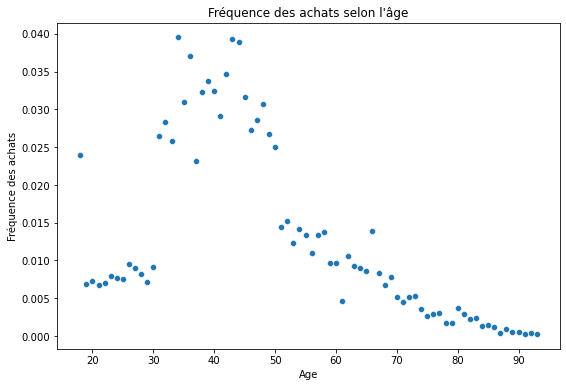

In [18]:
age_count = data.value_counts('age')
age_count = pd.DataFrame(age_count).reset_index()
age_count = age_count.rename(columns={0: 'total_sales'})
age_count['frequency'] = age_count['total_sales']/age_count['total_sales'].sum()

plt.figure(figsize=(9,6))
sns.scatterplot(x=age_count['age'], y=age_count['frequency'])
plt.title("Fréquence des achats selon l'âge")
plt.xlabel('Age')
plt.ylabel('Fréquence des achats')
plt.savefig('P6_age_frequence_achat_total.png', bbox_inches='tight', dpi=150)
plt.show()

Tests de corrélation

In [19]:
matrice_age = age_count['age'].to_numpy()
matrice_frq = age_count['frequency'].to_numpy()

# Test de Pearson effectué, mais pas adapté pour une distribution non paramétrique
pr = st.pearsonr(matrice_age, matrice_frq)

sp = st.spearmanr(matrice_age, matrice_frq)
kd = st.kendalltau(matrice_age, matrice_frq)

print(pr)
print(sp)
print(kd)

(-0.5744824507923254, 5.7503845077478365e-08)
SpearmanrResult(correlation=-0.6738255217212894, pvalue=2.5445448455176546e-11)
KendalltauResult(correlation=-0.5443060269792106, pvalue=3.4984753986981914e-12)


### Sur les sessions de vente

En groupant sur les clients

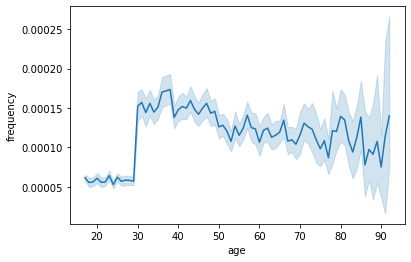

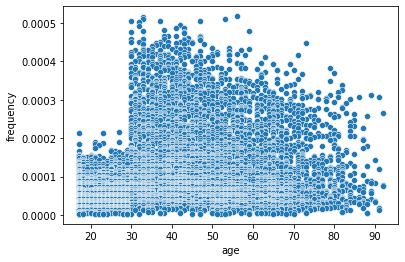

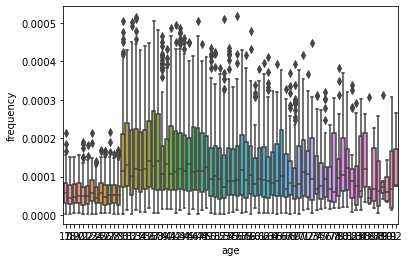

In [20]:
session = data.groupby(['client_id','session_id']).sum()
session_count = session.value_counts('client_id')
session_count = pd.DataFrame(session_count).reset_index()
session_count = pd.merge(left=session_count, right=customers, on='client_id')
session_count['age'] = 2021 - session_count['birth']
session_count = session_count.rename(columns={0: 'total_session'})
session_count['frequency'] = session_count['total_session']/session_count['total_session'].sum()

sns.lineplot(x=session_count['age'], y=session_count['frequency'])
plt.show()
sns.scatterplot(x=session_count['age'], y=session_count['frequency'])
plt.show()
sns.boxplot(x=session_count['age'], y=session_count['frequency'])
plt.show()


En groupant sur les âges

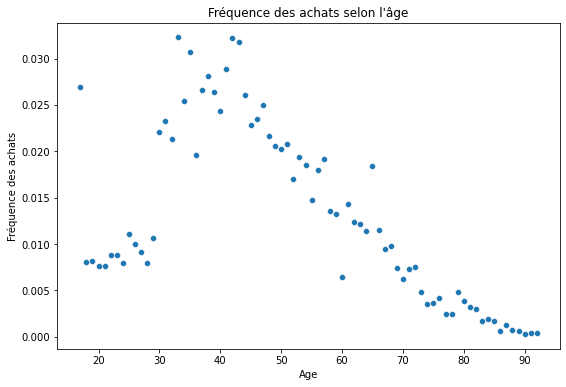

In [21]:
age_session_count = session_count[['age', 'total_session']].groupby(['age']).sum().reset_index()
age_session_count['frequency'] = age_session_count['total_session']/age_session_count['total_session'].sum()

plt.figure(figsize=(9,6))
sns.scatterplot(x=age_session_count['age'], y=age_session_count['frequency'])
plt.title("Fréquence des achats selon l'âge")
plt.xlabel('Age')
plt.ylabel('Fréquence des achats')
plt.savefig('P6_age_frequence_achat_session.png', bbox_inches='tight', dpi=150)
plt.show()

Tests de corrélation

In [22]:
matrice_age = age_session_count['age'].to_numpy()
matrice_frq = age_session_count['frequency'].to_numpy()

# Test de Pearson effectué, mais pas adapté pour une distribution non paramétrique
pr = st.pearsonr(matrice_age, matrice_frq)

sp = st.spearmanr(matrice_age, matrice_frq)
kd = st.kendalltau(matrice_age, matrice_frq)

print(pr)
print(sp)
print(kd)

(-0.6012303492621693, 9.30562727225924e-09)
SpearmanrResult(correlation=-0.6593848257006152, pvalue=9.36237939303452e-11)
KendalltauResult(correlation=-0.544561403508772, pvalue=3.390564520855647e-12)


## Age des clients et taille du panier moyen

In [23]:
total_session = data.groupby(['client_id', 'session_id', 'age']).sum().reset_index()
mean_clients = total_session.groupby(['client_id', 'age']).mean().reset_index()

# En groupant sur les âges
mean_age = total_session.groupby(['age']).mean().reset_index()

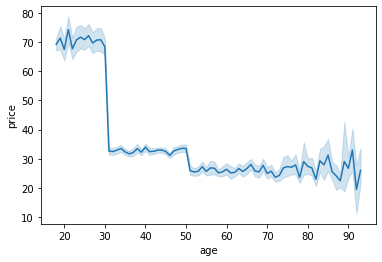

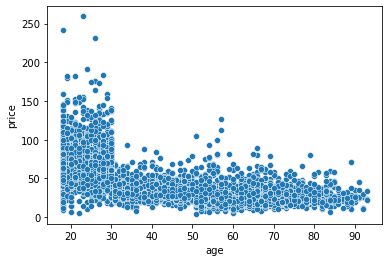

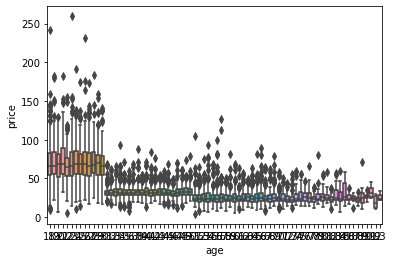

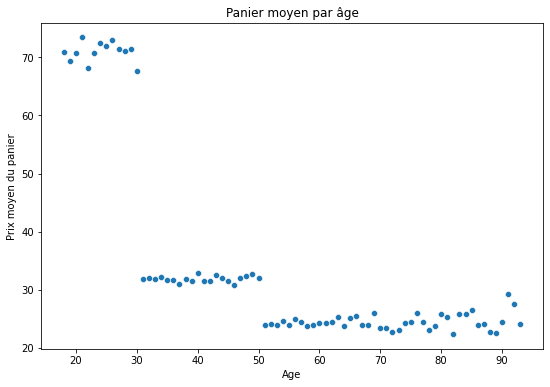

In [24]:
sns.lineplot(x=mean_clients['age'], y=mean_clients['price'])
plt.show()
sns.scatterplot(x=mean_clients['age'], y=mean_clients['price'])
plt.show()
sns.boxplot(x=mean_clients['age'], y=mean_clients['price'])
plt.show()

plt.figure(figsize=(9,6))
sns.scatterplot(data=mean_age, x='age', y='price')
plt.title("Panier moyen par âge")
plt.xlabel("Age")
plt.ylabel("Prix moyen du panier")
plt.savefig("P6_age_mean.png",bbox_inches='tight',dpi=150)
plt.show()

In [25]:
matrice_age = mean_age['age']
matrice_pm = mean_age['price']

# Test de Pearson effectué, mais pas adapté pour une distribution non paramétrique
pr = st.pearsonr(matrice_age, matrice_pm)

sp = st.spearmanr(matrice_age, matrice_pm)
kd = st.kendalltau(matrice_age, matrice_pm)

print(pr)
print(sp)
print(kd)

(-0.7456330695509896, 1.1045425340554188e-14)
SpearmanrResult(correlation=-0.7662337662337663, pvalue=7.299148357774815e-16)
KendalltauResult(correlation=-0.5515789473684211, pvalue=1.7865866224325619e-12)


## Age des clients et catégories de livres achetés

Représentation des catégories selon l'âge des clients

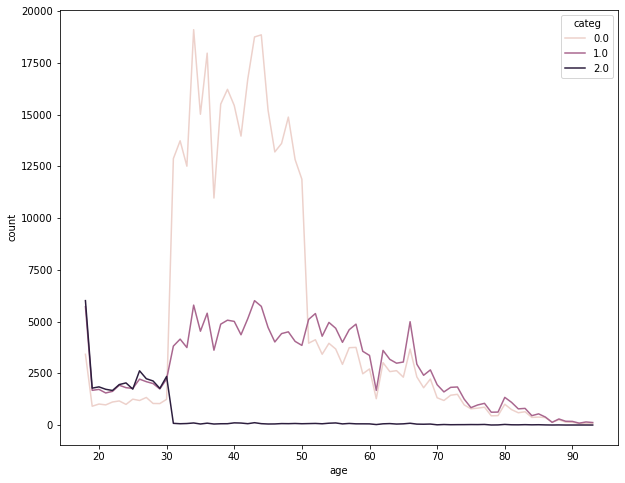

In [26]:
age_categ = data.groupby(['age'])['categ'].value_counts()
age_categ = pd.DataFrame(age_categ)
age_categ = age_categ.rename(columns={'categ': 'count'})
age_categ = age_categ.reset_index()

plt.figure(figsize=(10,8))
sns.lineplot(data=age_categ, x='age', y='count', hue='categ')
plt.show()

Test de Kruskal-Wallis

In [27]:
client_categ = pd.crosstab(data['age'], data['categ']).reset_index()

categ_0 = st.kruskal(client_categ['age'], client_categ[0.0])
categ_1 = st.kruskal(client_categ['age'], client_categ[1.0])
categ_2 = st.kruskal(client_categ['age'], client_categ[2.0])
all_categ = st.kruskal(client_categ['age'], client_categ[0.0], client_categ[1.0], client_categ[2.0])
print("Test de Kruskal-Wallis entre âge et categ 0.0 :", categ_0)
print("Test de Kruskal-Wallis entre âge et categ 1.0 :", categ_1)
print("Test de Kruskal-Wallis entre âge et categ 2.0 :", categ_2)
print("Test de Kruskal-Wallis entre âge et toutes catégories :", all_categ)

Test de Kruskal-Wallis entre âge et categ 0.0 : KruskalResult(statistic=109.32968108161127, pvalue=1.374190887694931e-25)
Test de Kruskal-Wallis entre âge et categ 1.0 : KruskalResult(statistic=113.05910156943771, pvalue=2.094379952963576e-26)
Test de Kruskal-Wallis entre âge et categ 2.0 : KruskalResult(statistic=0.09131721770480321, pvalue=0.7625092177136297)
Test de Kruskal-Wallis entre âge et toutes catégories : KruskalResult(statistic=188.6673680102077, pvalue=1.1843332274780199e-40)


# Q3 : Etude de la probabilité d'achat 0_525 sachant 2_159

Calcule des probabilités qu'un client achète 0_525 ou 2_159 :  
(Utilisation des données originales avec les 4 clients mis de côtés)

In [31]:
ref0_525 = data_original.loc[data_original['id_prod'] == '0_525']
ref0_525 = ref0_525['client_id'].nunique()

ref2_159 = data_original.loc[data_original['id_prod'] == '2_159']
ref2_159 = ref2_159['client_id'].nunique()

P_A = ref0_525/data_original['client_id'].nunique()
P_B = ref2_159/data_original['client_id'].nunique()
print("Le nombre de clients ayant acheyé la ref 0_525 :", ref0_525)
print("Le nombre de clients ayant acheyé la ref 2_159 :", ref2_159)
print("Probabilité qu'un client achète la ref 0_525 :", P_A)
print("Probabilité qu'un client achète la ref 2_159 :", P_B)

Le nombre de clients ayant acheyé la ref 0_525 : 459
Le nombre de clients ayant acheyé la ref 2_159 : 530
Probabilité qu'un client achète la ref 0_525 : 0.053372093023255816
Probabilité qu'un client achète la ref 2_159 : 0.06162790697674419


Calcul de la probabilité qu'un client achète 0_525 et 2_159 :

In [33]:
prod_loc = data_original.loc[(data_original['id_prod'] == '0_525') | (data_original['id_prod'] == '2_159')]
client_prod = prod_loc.groupby(['client_id']).agg('nunique')
client_P = client_prod.loc[client_prod['id_prod'] > 1]

print("Le nombre de clients ayant acheté la ref 0_525 et la ref 2_159 :", len(client_P))
print("Probabilité qu'un client achète la ref 0_525 et la ref 2_159 :", len(client_P)/data_original['client_id'].nunique())

Le nombre de clients ayant acheté la ref 0_525 et la ref 2_159 : 459
Probabilité qu'un client achète la ref 0_525 et la ref 2_159 : 0.053372093023255816


La probabilité d'acheter ref 0_525 est égale à la probabilité d'acheter ref 0_525 et ref 2_159.  
Donc P(A inter B) = P(A)

In [34]:
P_AB = P_A/P_B
print("Probabilité qu'un client achète la ref 0_525 sachant qu'il a acheté la ref 2_159 :", P_AB)
print("Donc probabilité de :", P_AB*100,"%")

Probabilité qu'un client achète la ref 0_525 sachant qu'il a acheté la ref 2_159 : 0.8660377358490566
Donc probabilité de : 86.60377358490567 %
